# Load Data and Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
%matplotlib inline

df_listings_bos = pd.read_csv('./boston/listings.csv')
#df_calendar_bos = pd.read_csv('./boston/calendar.csv')
#df_review_bos = pd.read_csv('./boston/reviews.csv')

df_listings_sea = pd.read_csv('./seattle/listings.csv')
#df_calendar_sea = pd.read_csv('./seattle/calendar.csv')
#df_review_sea = pd.read_csv('./seattle/reviews.csv')

In [3]:
df_listings_bos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

In [4]:
df_listings_sea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [5]:
def clean_data(df, is_bos=True):
    
    
    
    #Drop columns that are not quantitative nor categorical for price prediction
    drop_columns = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary','space',
                    'description', 'experiences_offered', 'neighborhood_overview', 'notes','transit',
                     'thumbnail_url', 'medium_url', 'picture_url', 'has_availability',
                    'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_about', 'host_response_time',
                    'host_response_rate', 'host_acceptance_rate', 'host_thumbnail_url', 'host_picture_url',
                    'host_neighbourhood', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
                    'street', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location',
                    'country_code', 'country', 'calendar_updated', 'calendar_last_scraped', 'jurisdiction_names',
                    'first_review', 'last_review', 'requires_license'
                   ]
    # The extra columns which only df_listings_bos has
    drop_columns_bos_extra = ['access', 'interaction', 'house_rules']
    
    df = df.drop(columns=drop_columns)
    
    # Drop the columns only in boston dataset
    if is_bos:
        df = df.drop(columns=drop_columns_bos_extra)
    
    # Drop columns that have less than 60% non-null value
    df.dropna(axis=1, thresh=len(df)*0.6, inplace=True)

    # Convert $ string into float
    for mon_col in ["cleaning_fee", "price", "extra_people"]:
        df[mon_col] = df[mon_col].str.replace("[$, ]", "").astype("float")
    
    # Convert t/f into binary True/False
    df["is_location_exact"]=df["is_location_exact"].apply(lambda x:True if x=="t" else False)
    df["host_is_superhost"]=df["host_is_superhost"].apply(lambda x:True if x=="t" else False)
    df["instant_bookable"]=df["instant_bookable"].apply(lambda x:True if x=="t" else False)
    df["require_guest_profile_picture"]=df["require_guest_profile_picture"].apply(lambda x:True if x=="t" else False)
    df["require_guest_phone_verification"]=df["require_guest_phone_verification"].apply(lambda x:True if x=="t" else False)
    # Convert string to datetime
    df["host_since"] = pd.to_datetime(df["host_since"])
    
    # The listing with NaN in cleaning fee should be 0
    df["cleaning_fee"].fillna(0, inplace=True)
    
    # Drop the rows without bathroom, bedroom, host_location ,bed and property_type since they only have very few missing value
    df.dropna(subset=["bathrooms", "bedrooms", "beds", "property_type", "host_location"], inplace=True)
    
    # Fill in the missing values in review with the mean
    for review in ["review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin",
                  "review_scores_communication", "review_scores_location", "review_scores_value", "reviews_per_month" ]:
        df[review].fillna(df[review].mean(), inplace=True)
    return df

df_listings_bos = clean_data(df_listings_bos)
df_listings_sea = clean_data(df_listings_sea, False)

In [6]:
df_listings_sea.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3787 entries, 0 to 3817
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                3787 non-null   int64         
 1   host_since                        3787 non-null   datetime64[ns]
 2   host_location                     3787 non-null   object        
 3   host_is_superhost                 3787 non-null   bool          
 4   host_listings_count               3787 non-null   float64       
 5   host_total_listings_count         3787 non-null   float64       
 6   neighbourhood                     3372 non-null   object        
 7   neighbourhood_cleansed            3787 non-null   object        
 8   latitude                          3787 non-null   float64       
 9   longitude                         3787 non-null   float64       
 10  is_location_exact                 3787 non-null 

In [7]:
df_listings_sea.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3787 entries, 0 to 3817
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                3787 non-null   int64         
 1   host_since                        3787 non-null   datetime64[ns]
 2   host_location                     3787 non-null   object        
 3   host_is_superhost                 3787 non-null   bool          
 4   host_listings_count               3787 non-null   float64       
 5   host_total_listings_count         3787 non-null   float64       
 6   neighbourhood                     3372 non-null   object        
 7   neighbourhood_cleansed            3787 non-null   object        
 8   latitude                          3787 non-null   float64       
 9   longitude                         3787 non-null   float64       
 10  is_location_exact                 3787 non-null 

count    3543.000000
mean      174.300875
std       148.900712
min        10.000000
25%        85.000000
50%       150.000000
75%       220.000000
max      4000.000000
Name: price, dtype: float64

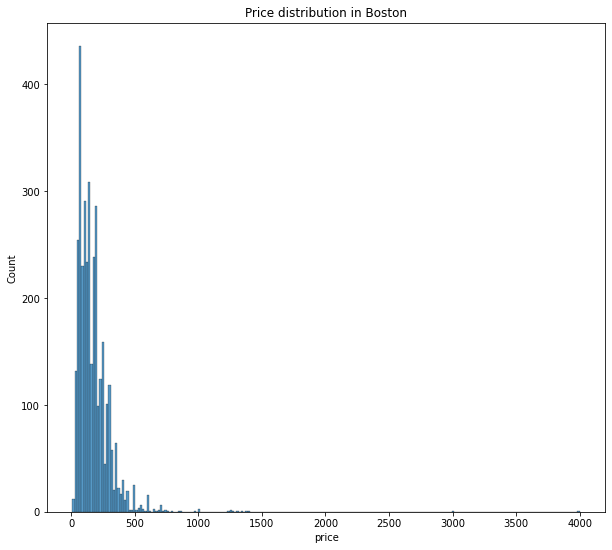

In [8]:
plt.figure(figsize=(10,9))
plt.title('Price distribution in Boston')
ax = sns.histplot(df_listings_bos['price'])
df_listings_bos['price'].describe()

count    3787.000000
mean      128.063375
std        90.463742
min        20.000000
25%        75.000000
50%       100.000000
75%       150.000000
max      1000.000000
Name: price, dtype: float64

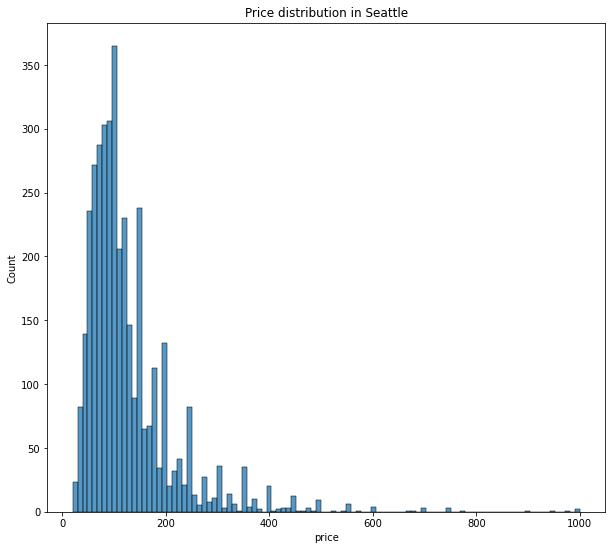

In [9]:
plt.figure(figsize=(10,9))
plt.title('Price distribution in Seattle')
ax = sns.histplot(df_listings_sea['price'])
df_listings_sea['price'].describe()

## Numerical variables

In [10]:
num_col_bos = df_listings_bos.select_dtypes(include=['float', 'int'])
num_col_sea = df_listings_sea.select_dtypes(include=['float', 'int'])
num_col_bos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3543 entries, 0 to 3584
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              3543 non-null   int64  
 1   host_listings_count             3543 non-null   int64  
 2   host_total_listings_count       3543 non-null   int64  
 3   latitude                        3543 non-null   float64
 4   longitude                       3543 non-null   float64
 5   accommodates                    3543 non-null   int64  
 6   bathrooms                       3543 non-null   float64
 7   bedrooms                        3543 non-null   float64
 8   beds                            3543 non-null   float64
 9   price                           3543 non-null   float64
 10  cleaning_fee                    3543 non-null   float64
 11  guests_included                 3543 non-null   int64  
 12  extra_people                    35

In [11]:
num_col_bos.corr()['price'].sort_values(ascending=False).to_frame()


,price
price,1.000000
accommodates,0.436878
bedrooms,0.385169
beds,0.370361
cleaning_fee,0.298278
bathrooms,0.248676
guests_included,0.211122
latitude,0.195678
host_total_listings_count,0.169467
host_listings_count,0.169467


In [12]:
num_col_sea.corr()['price'].sort_values(ascending=False).to_frame()

,price
price,1.000000
accommodates,0.652240
bedrooms,0.628585
beds,0.589944
cleaning_fee,0.578767
bathrooms,0.516876
guests_included,0.393803
extra_people,0.128363
host_listings_count,0.093636
host_total_listings_count,0.093636


We can see that price, accommodates, bedrooms, beds, cleaning_fee, bathrooms, guests_included are highly correlated to price

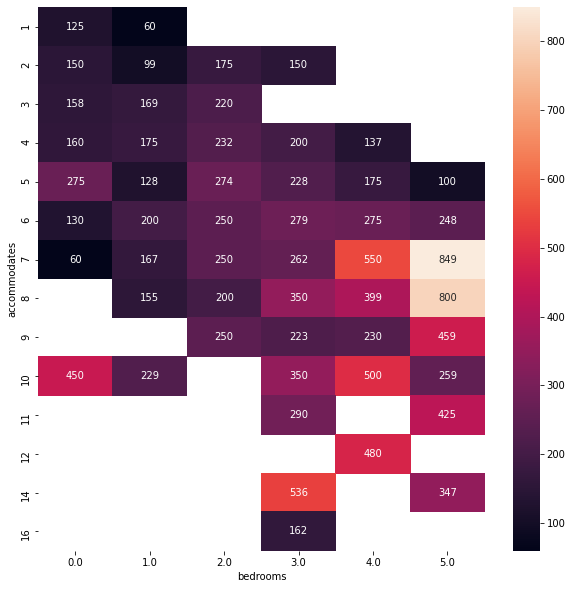

In [13]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(df_listings_bos.groupby(['accommodates', 'bedrooms']).median()['price'].unstack(), annot=True, fmt=".0f")

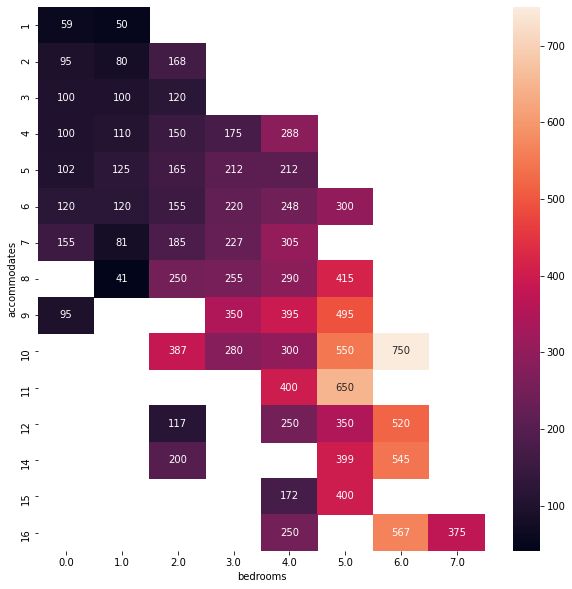

In [14]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(df_listings_sea.groupby(['accommodates', 'bedrooms']).median()['price'].unstack(), annot=True, fmt=".0f")

## Categorical Variables

In [15]:
cat_col = df_listings_bos.select_dtypes(include=['object'])
cat_col.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3543 entries, 0 to 3584
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   host_location           3543 non-null   object
 1   neighbourhood           3010 non-null   object
 2   neighbourhood_cleansed  3543 non-null   object
 3   property_type           3543 non-null   object
 4   room_type               3543 non-null   object
 5   bed_type                3543 non-null   object
 6   amenities               3543 non-null   object
 7   cancellation_policy     3543 non-null   object
dtypes: object(8)
memory usage: 249.1+ KB


In [16]:
df_listings_bos.host_location.value_counts()

Boston, Massachusetts, United States              2411
US                                                 504
New York, New York, United States                  112
Montreal, Quebec, Canada                            58
Middlesex County, Massachusetts, United States      50
                                                  ... 
IT                                                   1
Albuquerque, New Mexico, United States               1
Santos, State of São Paulo, Brazil                   1
Charleston, South Carolina, United States            1
California                                           1
Name: host_location, Length: 176, dtype: int64

### neighbourhood_cleansed

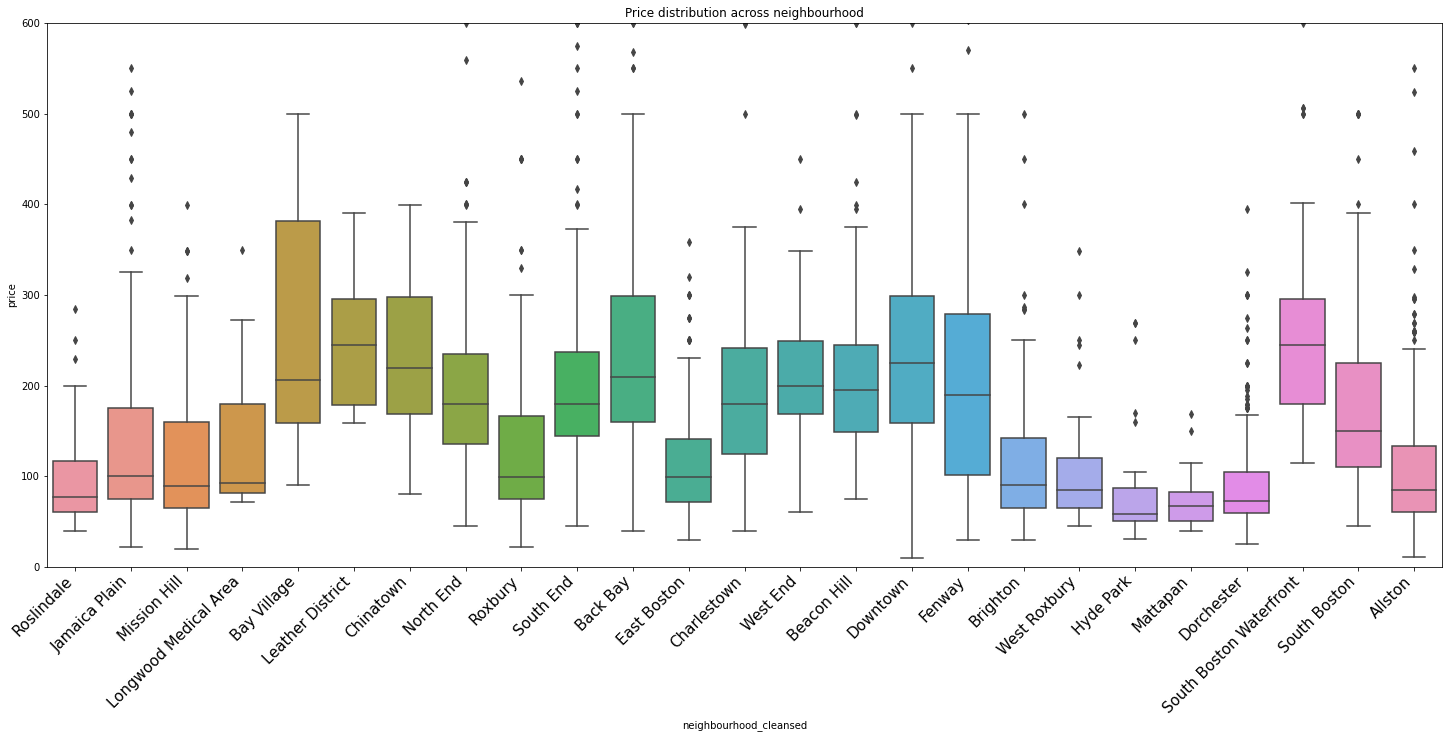

In [17]:
plt.figure(figsize=(25,10))
plt.title("Price distribution across neighbourhood")

sns.boxplot(data=df_listings_bos, x='neighbourhood_cleansed', y='price')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=15)

plt.ylim([0,600])
plt.show()

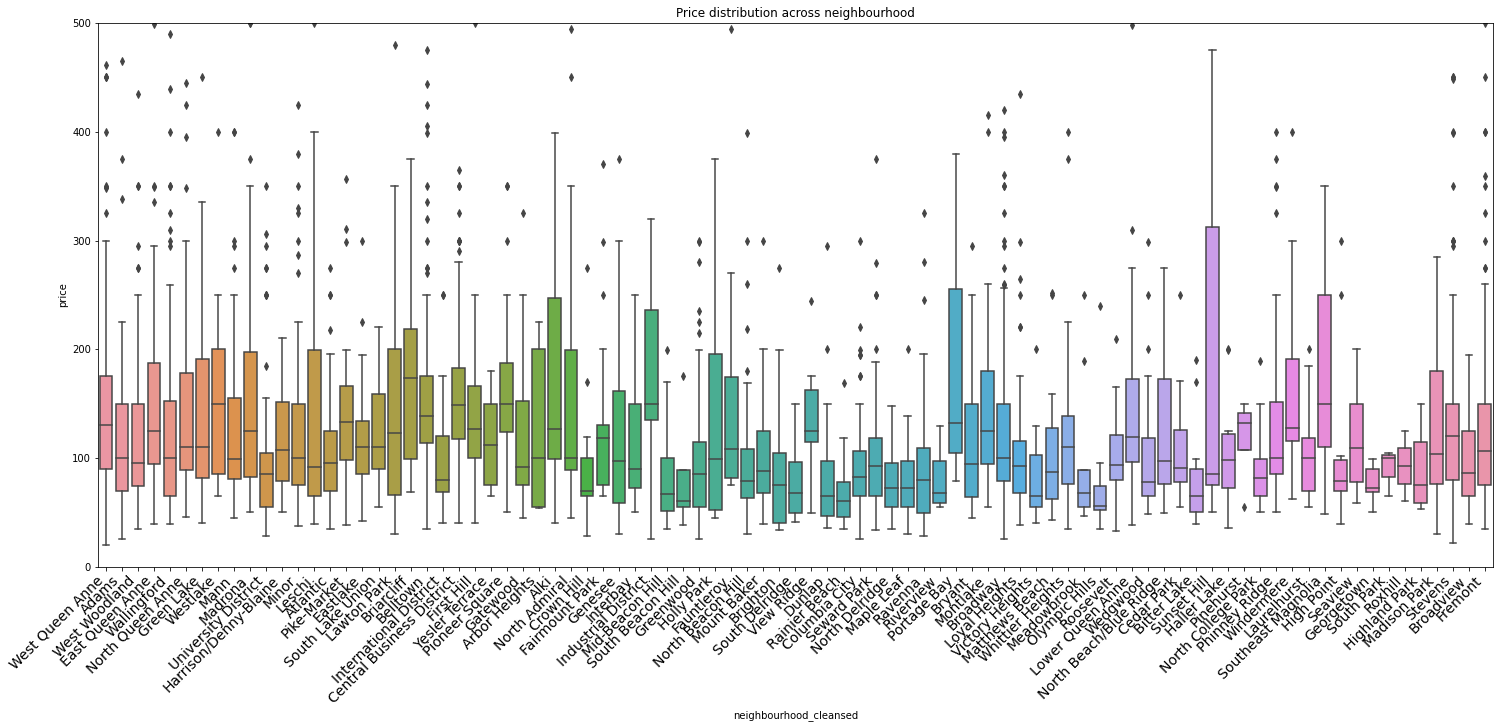

In [18]:
plt.figure(figsize=(25,10))
plt.title("Price distribution across neighbourhood")

sns.boxplot(data=df_listings_sea, x='neighbourhood_cleansed', y='price')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=14)

plt.ylim([0,500])
plt.show()

In [19]:
df_listings_bos['host_location'].value_counts()

Boston, Massachusetts, United States              2411
US                                                 504
New York, New York, United States                  112
Montreal, Quebec, Canada                            58
Middlesex County, Massachusetts, United States      50
                                                  ... 
IT                                                   1
Albuquerque, New Mexico, United States               1
Santos, State of São Paulo, Brazil                   1
Charleston, South Carolina, United States            1
California                                           1
Name: host_location, Length: 176, dtype: int64

<Figure size 720x648 with 0 Axes>

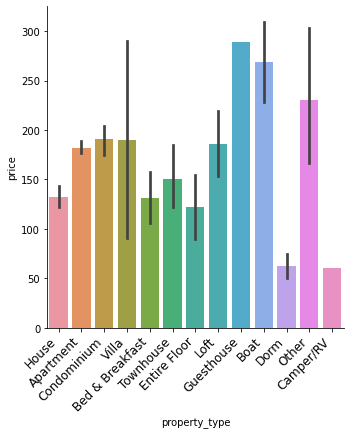

In [20]:
plt.figure(figsize=(10,9))
gx = sns.catplot(x='property_type', y='price', kind='bar', data=df_listings_bos)
gx.set_xticklabels(rotation=45, ha='right', fontsize=12)

<Figure size 720x648 with 0 Axes>

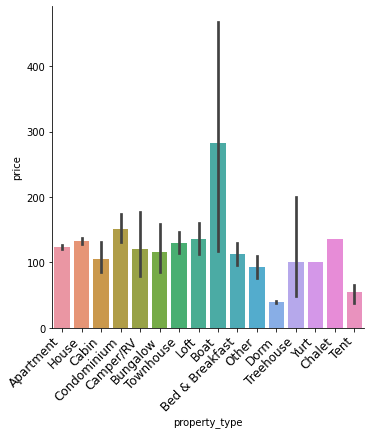

In [21]:
plt.figure(figsize=(10,9))
gx = sns.catplot(x='property_type', y='price', kind='bar', data=df_listings_sea)
gx.set_xticklabels(rotation=45, ha='right', fontsize=12)

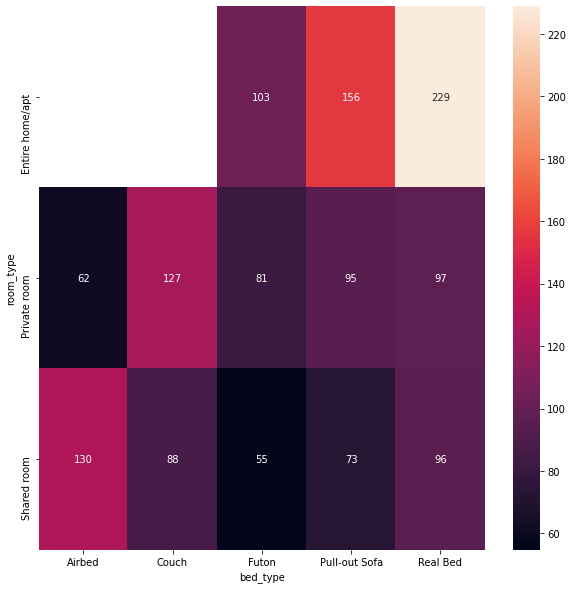

In [22]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(df_listings_bos.groupby(['room_type', 'bed_type']).mean()['price'].unstack(), annot=True, fmt=".0f")

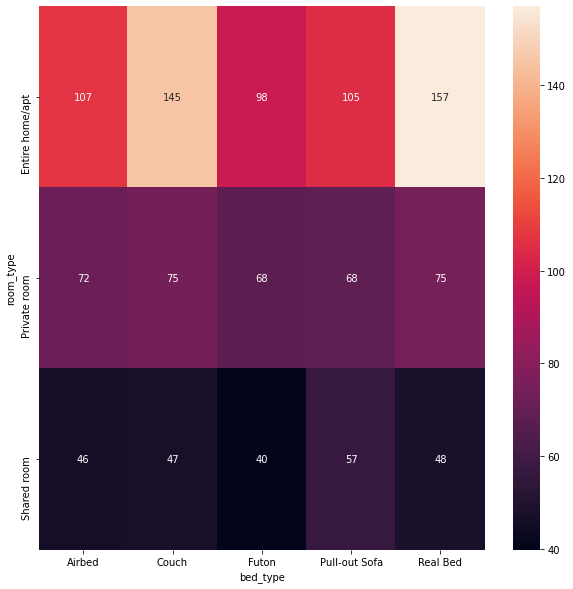

In [23]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(df_listings_sea.groupby(['room_type', 'bed_type']).mean()['price'].unstack(), annot=True, fmt=".0f")

In [24]:
df_listings_sea.groupby('cancellation_policy').mean().price

cancellation_policy
flexible    109.361404
moderate    114.965406
strict      154.844729
Name: price, dtype: float64

In [25]:
df_listings_bos.groupby('cancellation_policy').mean().price

cancellation_policy
flexible           149.798379
moderate           162.870330
strict             188.632718
super_strict_30    335.240000
Name: price, dtype: float64

In [26]:
cancellation_policy_price = pd.concat([df_listings_sea.groupby('cancellation_policy').mean().price.rename('Seattle price'), df_listings_bos.groupby('cancellation_policy').mean().price.rename('Boston price')], axis=1)

In [27]:
cancellation_policy_price

,Seattle price,Boston price
flexible,109.361404,149.798379
moderate,114.965406,162.870330
strict,154.844729,188.632718
super_strict_30,NaN,335.240000


In [28]:
df_listings_bos.select_dtypes(include=['bool']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3543 entries, 0 to 3584
Data columns (total 5 columns):
 #   Column                            Non-Null Count  Dtype
---  ------                            --------------  -----
 0   host_is_superhost                 3543 non-null   bool 
 1   is_location_exact                 3543 non-null   bool 
 2   instant_bookable                  3543 non-null   bool 
 3   require_guest_profile_picture     3543 non-null   bool 
 4   require_guest_phone_verification  3543 non-null   bool 
dtypes: bool(5)
memory usage: 205.0 KB


### host_is_superhost

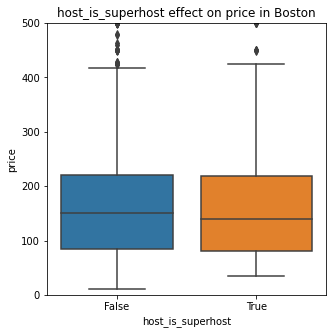

In [29]:
plt.figure(figsize=(5,5))
plt.title("host_is_superhost effect on price in Boston")

sns.boxplot(data=df_listings_bos, x='host_is_superhost', y='price')

plt.ylim([0,500])
plt.show()

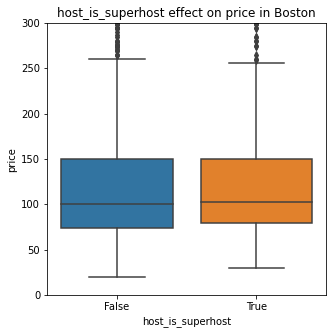

In [30]:
plt.figure(figsize=(5,5))
plt.title("host_is_superhost effect on price in Boston")

sns.boxplot(data=df_listings_sea, x='host_is_superhost', y='price')

plt.ylim([0,300])
plt.show()

### is_location_exact

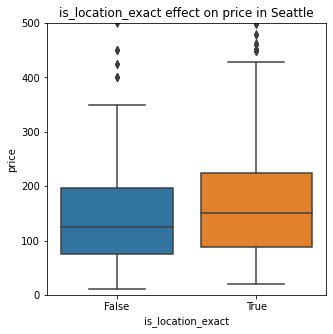

In [31]:
plt.figure(figsize=(5,5))
plt.title("is_location_exact effect on price in Seattle")

sns.boxplot(data=df_listings_bos, x='is_location_exact', y='price')

plt.ylim([0,500])
plt.show()

In [ ]:
plt.figure(figsize=(5,5))
plt.title("is_location_exact effect on price in Seattle")

sns.boxplot(data=df_listings_sea, x='is_location_exact', y='price')

plt.ylim([0,300])
plt.show()

### instant_bookable

In [ ]:
plt.figure(figsize=(5,5))
plt.title("instant_bookable effect on price")

sns.boxplot(data=df_listings_bos, x='instant_bookable', y='price')


plt.ylim([0,500])
plt.show()

In [ ]:
plt.figure(figsize=(5,5))
plt.title("instant_bookable effect on price")

sns.boxplot(data=df_listings_sea, x='instant_bookable', y='price')


plt.ylim([0,300])
plt.show()

### require_guest_phone_verification

In [ ]:
plt.figure(figsize=(5,5))
plt.title("require_guest_phone_verification effect on price")

sns.boxplot(data=df_listings_bos, x='require_guest_phone_verification', y='price')

plt.ylim([0,600])
plt.show()

In [ ]:
plt.figure(figsize=(5,5))
plt.title("require_guest_phone_verification effect on price")

sns.boxplot(data=df_listings_sea, x='require_guest_phone_verification', y='price')

plt.ylim([0,400])
plt.show()

## Choose variables to train our model

In [ ]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    Perform to obtain the correct X and y objects
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no salaries
    2. Create X as all the columns that are not the Salary column
    3. Create y as the Salary column
    4. Drop the Salary, Respondent, and the ExpectedSalary columns from X
    5. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    # We select top 15 numerical variable correlated to price
    corr_num_vars = ['accommodates', 'bedrooms', 'beds', 'cleaning_fee', 'bathrooms', 'guests_included', 'reviews_per_month',
                    'longitude', 'host_listings_count', 'host_total_listings_count','number_of_reviews', 'calculated_host_listings_count',
                    'latitude', 'review_scores_location','availability_30' ]
    
    # We select Categorical variable correlated to price
    corr_cat_vars = ['neighbourhood_cleansed','property_type', 'room_type', 'bed_type', 'cancellation_policy']
    
    X = df[corr_num_vars + corr_cat_vars]
    y = df['price']
    
    X = create_dummy_df(X, corr_cat_vars, True)
    
    
    return X, y

In [ ]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [ ]:
X, y = clean_data(df_listings_bos)

# split test and train dataset from X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
def evaluate_model(_model, x_train, y_train, x_test, y_test):
    _model.fit(x_train, y_train)
    _prediction = _model.predict(x_test)
    _mean_abs_err = mean_absolute_error(y_test, _prediction)
    
    fig, axs = plt.subplots(1, 2, figsize=(24, 8), dpi=80)
    axs[0].set_title('Distribution of predicted vs actual values')
    ax1 = sns.kdeplot(data=y_test, color="g", label='Actual values', ax=axs[0])
    ax2 = sns.kdeplot(data=_prediction, color="r", label='Predicted values', ax=ax1)
    
    sns.regplot(x=y_test, y=_prediction)
    plt.title('Distribution of predicted vs actual values')
    plt.xlabel('Price')
    plt.show()
    plt.close()
    
    print("Mean absolute error of {0}: {1}".format(_model, _mean_abs_err))

# Create instance of Random Forest Regressor and evaluate model
model = RandomForestRegressor(n_estimators=80, random_state=42)    
model.fit(X_train, y_train)
prediction = model.predict(X_test)
mse = mean_squared_error(y_test, prediction)
r2 = r2_score(y_test, prediction)


plt.figure(figsize=(24, 8))
plt.title('Distribution of predicted vs actual values')
ax1 = sns.kdeplot(data=y_test, color="g", label='Actual values')
ax2 = sns.kdeplot(data=prediction, color="r", label='Predicted values')
    

plt.xlabel('Price')
plt.show()
print("Mean squared error of {0}: {1}".format(model, mse))
print("R2 score : {0}".format(r2))
